# Reproducible figures for actifpTM calculation

<a href="https://colab.research.google.com/github/Furman-Lab/peptide_docking_af/blob/main/actifptm_matrices_paper_figures_probs.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>This notebook contains the code for reproducing figures for:  
actifpTM: a refined confidence metric of AlphaFold2 predictions involving flexible regions  
Julia K. Varga, Sergey Ovchinnikov and Ora Schueler-Furman

  
[Original notebook from Sergey Ovchinnikov](https://colab.research.google.com/github/sokrypton/ColabDesign/blob/gamma/af/examples/predict.ipynb) modified by Julia K. Varga

In [1]:
%load_ext autoreload
%autoreload 2

!pip install biopandas

#@title setup
unified_memory = True
import os, time, gc
if unified_memory:
  ENV = {"TF_FORCE_UNIFIED_MEMORY":"1", "XLA_PYTHON_CLIENT_MEM_FRACTION":"4.0"}
  for k,v in ENV.items(): os.environ[k] = v
if not os.path.isdir("params"):
  # get code
  print("installing ColabDesign")
  os.system("(mkdir params; apt-get install aria2 -qq; \
  aria2c -q -x 16 https://storage.googleapis.com/alphafold/alphafold_params_2022-12-06.tar; \
  tar -xf alphafold_params_2022-12-06.tar -C params; touch params/done.txt )&")

  os.system("pip -q install git+https://github.com/gezmi/ColabDesign.git@actifptm")
  os.system("ln -s /usr/local/lib/python3.*/dist-packages/colabdesign colabdesign")
  os.system("wget https://raw.githubusercontent.com/sokrypton/ColabFold/main/colabfold/colabfold.py -O colabfold_utils.py")
  os.system("wget https://raw.githubusercontent.com/gezmi/ColabFold/actifptm/colabfold/alphafold/extended_metrics.py -O extended_metrics.py")  # TODO: change to sokrypton
  #os.system("wget https://raw.githubusercontent.com/sokrypton/ColabFold/beta/colabfold/mmseqs/api.py")

  # install hhsuite
  print("installing HHsuite")
  os.makedirs("hhsuite", exist_ok=True)
  os.system(f"curl -fsSL https://github.com/soedinglab/hh-suite/releases/download/v3.3.0/hhsuite-3.3.0-SSE2-Linux.tar.gz | tar xz -C hhsuite/")

  # download params
  if not os.path.isfile("params/done.txt"):
    print("downloading AlphaFold params")
    while not os.path.isfile("params/done.txt"):
      time.sleep(5)
if "hhsuite" not in os.environ['PATH']:
  os.environ['PATH'] += ":hhsuite/bin:hhsuite/scripts"

import re, tempfile
from IPython.display import HTML
from google.colab import files
import numpy as np
from colabdesign import mk_af_model, clear_mem
from colabdesign.af.contrib import predict
from colabdesign.af.contrib.cyclic import add_cyclic_offset
from colabdesign.shared.protein import _np_rmsd, _np_kabsch
from colabdesign.shared.plot import plot_pseudo_3D, pymol_cmap


import jax
import jax.numpy as jnp
from colabfold_utils import run_mmseqs2
import matplotlib.pyplot as plt
import string
import numpy as np

def clear_mem():
  backend = jax.lib.xla_bridge.get_backend()
  for buf in backend.live_buffers(): buf.delete()

def get_pdb(pdb_code=""):
  if pdb_code is None or pdb_code == "":
    upload_dict = files.upload()
    pdb_string = upload_dict[list(upload_dict.keys())[0]]
    with open("tmp.pdb","wb") as out: out.write(pdb_string)
    return "tmp.pdb"
  elif os.path.isfile(pdb_code):
    return pdb_code
  elif len(pdb_code) == 4:
    os.makedirs("tmp",exist_ok=True)
    os.system(f"wget -qnc https://files.rcsb.org/download/{pdb_code}.cif -P tmp/")
    return f"tmp/{pdb_code}.cif"
  else:
    os.makedirs("tmp",exist_ok=True)
    os.system(f"wget -qnc https://alphafold.ebi.ac.uk/files/AF-{pdb_code}-F1-model_v4.pdb -P tmp/")
    return f"tmp/AF-{pdb_code}-F1-model_v4.pdb"

def run_hhalign(query_sequence, target_sequence, query_a3m=None, target_a3m=None):
  with tempfile.NamedTemporaryFile() as tmp_query, \
  tempfile.NamedTemporaryFile() as tmp_target, \
  tempfile.NamedTemporaryFile() as tmp_alignment:
    if query_a3m is None:
      tmp_query.write(f">Q\n{query_sequence}\n".encode())
      tmp_query.flush()
      query_a3m = tmp_query.name
    if target_a3m is None:
      tmp_target.write(f">T\n{target_sequence}\n".encode())
      tmp_target.flush()
      target_a3m = tmp_target.name
    os.system(f"hhalign -hide_cons -i {query_a3m} -t {target_a3m} -o {tmp_alignment.name}")
    X, start_indices = predict.parse_hhalign_output(tmp_alignment.name)
  return X, start_indices

def run_do_not_align(query_sequence, target_sequence, **arg):
  return [query_sequence,target_sequence],[0,0]

def run_hhfilter(input, output, id=90, qid=10):
  os.system(f"hhfilter -id {id} -qid {qid} -i {input} -o {output}")

@jax.jit
def get_coevolution(X):
  '''given one-hot encoded MSA, return contacts'''
  Y = jax.nn.one_hot(X,22)
  N,L,A = Y.shape
  Y_flat = Y.reshape(N,-1)
  # covariance
  c = jnp.cov(Y_flat.T)

  # inverse covariance
  shrink = 4.5/jnp.sqrt(N) * jnp.eye(c.shape[0])
  ic = jnp.linalg.inv(c + shrink)

  # partial correlation coefficient
  ic_diag = jnp.diag(ic)
  pcc = ic / jnp.sqrt(ic_diag[:,None] * ic_diag[None,:])

  raw = jnp.sqrt(jnp.square(pcc.reshape(L,A,L,A)[:,:20,:,:20]).sum((1,3)))
  i = jnp.arange(L)
  raw = raw.at[i,i].set(0)
  # do apc
  ap = raw.sum(0,keepdims=True) * raw.sum(1,keepdims=True) / raw.sum()
  return (raw - ap).at[i,i].set(0)

def plot_3D(aux, Ls, file_name, show=False):
  plt.figure(figsize=(10,5))
  xyz = aux["atom_positions"][:,1]
  xyz = xyz @ _np_kabsch(xyz, xyz, return_v=True, use_jax=False)
  ax = plt.subplot(1,2,1)
  if len(Ls) > 1:
    plt.title("chain")
    c = np.concatenate([[n]*L for n,L in enumerate(Ls)])
    plot_pseudo_3D(xyz=xyz, c=c, cmap=pymol_cmap, cmin=0, cmax=39, Ls=Ls, ax=ax)
  else:
    plt.title("length")
    plot_pseudo_3D(xyz=xyz, Ls=Ls, ax=ax)
  plt.axis(False)
  ax = plt.subplot(1,2,2)
  plt.title("plddt")
  plot_pseudo_3D(xyz=xyz, c=aux["plddt"], cmin=0.5, cmax=0.9, Ls=Ls, ax=ax)
  plt.axis(False)
  plt.savefig(file_name, dpi=200, bbox_inches='tight')
  plt.show() if show else plt.close()

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 68.3/68.3 kB 1.9 MB/s eta 0:00:00
installing ColabDesign
installing HHsuite
downloading AlphaFold params


In [2]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [3]:
#@title Run AF2
sequence = "GQLEEIAKQLEEIAWQLEEIAQG:GQLKKIAKQLKKIAYQLKKIAQG" # {type:"string"}
jobname = "a2b2" # {type:"string"}

def run_alphafold(sequence, jobname, copies=1):
  # **MSA options**
  msa_method = "mmseqs2" # ["mmseqs2","single_sequence", "custom_fas", "custom_a3m", "custom_sto"]
  pair_mode = "unpaired_paired" # ["unpaired_paired","paired","unpaired"] {type:"string"}
  # filtering options
  cov = 75 # ["0", "25", "50", "75", "90", "99"] {type:"raw"}
  id = 90 # ["90", "100"] {type:"raw"}
  qid = 0 # ["0", "10", "15", "20", "30"] {type:"raw"}
  do_not_filter = False # {type:"boolean"}

  # ----
  # **Templates options**
  template_mode = "none" # ["none", "mmseqs2", "custom"] {type:"string"}
  use_templates = template_mode in ["mmseqs2","custom"]
  pdb = "" # {type:"string"}
  chain = "A" # {type:"string"}
  rm_template_seq = False # {type:"boolean"}
  propagate_to_copies = True # {type:"boolean"}
  do_not_align = False # {type:"boolean"}
  rm_sidechain = rm_sequence = rm_template_seq

  # filter options
  sequence = sequence.upper()
  sequence = re.sub("[^A-Z:/()]", "", sequence.upper())
  sequence = re.sub("\(",":(", sequence)
  sequence = re.sub("\)","):", sequence)
  sequence = re.sub(":+",":",sequence)
  sequence = re.sub("/+","/",sequence)
  sequence = re.sub("^[:/]+","",sequence)
  sequence = re.sub("[:/]+$","",sequence)
  jobname = re.sub(r'\W+', '', jobname)

  # process sequence
  sequences = sequence.split(":")
  u_sequences = predict.get_unique_sequences(sequences)
  u_cyclic = [x.startswith("(") for x in u_sequences]
  u_sub_lengths = [[len(y) for y in x.split("/")] for x in u_sequences]
  u_sequences = [x.replace("(","").replace(")","").replace("/","") for x in u_sequences]
  if len(sequences) > len(u_sequences):
    print("WARNING: use copies to define homooligomers")
  u_lengths = [len(x) for x in u_sequences]
  sub_seq = "".join(u_sequences)
  seq = sub_seq * copies

  jobname = f"{jobname}_{predict.get_hash(seq)[:5]}"
  def check(folder): return os.path.exists(folder)
  if check(jobname):
    n = 0
    while check(f"{jobname}_{n}"): n += 1
    jobname = f"{jobname}_{n}"

  print("jobname",jobname)
  print(f"length={u_lengths} copies={copies}")

  input_opts = {"sequence":u_sequences,
                "copies":copies,
                "msa_method":msa_method,
                "pair_mode":pair_mode,
                "do_not_filter":do_not_filter,
                "cov":cov,
                "id":id,
                "template_mode":template_mode,
                "propagate_to_copies":propagate_to_copies}

  def run_mmseqs2_wrapper(*args, **kwargs):
    kwargs['user_agent'] = "colabdesign/gamma"
    return run_mmseqs2(*args, **kwargs)

  ##################
  # GET MSA
  ##################
  os.makedirs(jobname, exist_ok=True)

  Ls = [len(x) for x in u_sequences]
  print(os.getcwd())
  if msa_method == "mmseqs2":
    msa, deletion_matrix = predict.get_msa(u_sequences, jobname,
      mode=pair_mode,
      cov=cov, id=id, qid=qid, max_msa=4096,
      do_not_filter=do_not_filter,
      mmseqs2_fn=run_mmseqs2_wrapper,
      hhfilter_fn=run_hhfilter)

  elif msa_method == "single_sequence":
    with open(f"{jobname}/msa.a3m","w") as a3m:
      a3m.write(f">{jobname}\n{sub_seq}\n")
    msa, deletion_matrix = predict.parse_a3m(f"{jobname}/msa.a3m")

  else:
    msa_format = msa_method.split("_")[1]
    print(f"upload {msa_method}")
    msa_dict = files.upload()
    lines = []
    for k,v in msa_dict.items():
      lines += v.decode().splitlines()
    input_lines = []
    for line in lines:
      line = line.replace("\x00","")
      if len(line) > 0 and not line.startswith('#'):
        input_lines.append(line)
    with open(f"{jobname}/msa.{msa_format}","w") as msa:
      msa.write("\n".join(input_lines))
    if msa_format != "a3m":
      os.system(f"perl hhsuite/scripts/reformat.pl {msa_format} a3m {jobname}/msa.{msa_format} {jobname}/msa.a3m")
    if do_not_filter:
      os.system(f"hhfilter -qid 0 -id 100 -cov 0 -i {jobname}/msa.a3m -o {jobname}/msa.filt.a3m")
    else:
      os.system(f"hhfilter -qid {qid} -id {id} -cov {cov} -i {jobname}/msa.a3m -o {jobname}/msa.filt.a3m")
    msa, deletion_matrix = predict.parse_a3m(f"{jobname}/msa.filt.a3m")

  if len(msa) > 1:
    predict.plot_msa(msa, Ls)
    plt.savefig(f"{jobname}/msa_feats.png", dpi=200, bbox_inches='tight')
    plt.show()

  ##################
  if use_templates:
    print("aligning template")
    template_msa = f"{jobname}/msa.a3m"
    if template_mode == "mmseqs2":
      predict.get_msa(u_sequences, jobname,
        mode="unpaired",
        mmseqs2_fn=run_mmseqs2_wrapper,
        do_not_filter=True,
        do_not_return=True,
        output_a3m=f"{jobname}/msa_tmp.a3m")
      template_msa = f"{jobname}/msa_tmp.a3m"
      if not propagate_to_copies and copies > 1:
        new_msa = []
        with open(template_msa, "r") as handle:
          for line in handle:
            if not line.startswith(">"):
              new_msa.append(line.rstrip())
        with open(template_msa, "w") as handle:
          for n,seq in enumerate(new_msa):
            handle.write(f">{n}\n{seq*copies}\n")

      templates = {}
      print("ID\tpdb\tcid\tevalue")
      for line in open(f"{jobname}/msa/_env/pdb70.m8","r"):
        p = line.rstrip().split()
        M,target_id,qid,e_value = p[0],p[1],p[2],p[10]
        M = int(M)
        if M not in templates:
          templates[M] = []
        if len(templates[M]) < 4:
          print(f"{int(M)}\t{target_id}\t{qid}\t{e_value}")
          templates[M].append(target_id)
      if len(templates) == 0:
        use_templates = False
        print("ERROR: no templates found...")
      else:
        Ms = sorted(list(templates.keys()))
        pdbs,chains = [],[]
        for M in Ms:
          for n,target_id in enumerate(templates[M]):
            pdb_id,chain_id = target_id.split("_")
            if len(pdbs) < n+1:
              pdbs.append([])
              chains.append([])
            pdbs[n].append(pdb_id)
            chains[n].append(chain_id)
        print(pdbs)
    else:
      pdbs,chains = [pdb],[chain]

  if use_templates:
    input_opts.update({"pdbs":pdbs, "chains":chains})
    batches = []
    for pdb,chain in zip(pdbs,chains):
      query_seq = "".join(u_sequences)
      batch = predict.get_template_feats(pdb, chain,
        query_seq=query_seq,
        query_a3m=template_msa,
        copies=copies,
        propagate_to_copies=propagate_to_copies,
        use_seq=not rm_sequence,
        get_pdb_fn=get_pdb,
        align_fn=run_do_not_align if do_not_align else run_hhalign)
      batches.append(batch)

    # for display
    plt.figure(figsize=(3*len(batches),3))
    for n,batch in enumerate(batches):
      plt.subplot(1,len(batches),n+1)
      plt.title(f"template features {n+1}")
      dgram = batch["dgram"].argmax(-1).astype(float)
      dgram[batch["dgram"].sum(-1) == 0] = np.nan
      Ln = dgram.shape[0]
      plt.imshow(dgram, extent=(0, Ln, Ln, 0))
      predict.plot_ticks(Ls * copies)
    plt.savefig(f"{jobname}/template_feats.png", dpi=200, bbox_inches='tight')
    plt.show()
  else:
    batches = [None]

  rank_by = "auto" # ["auto", "plddt", "ptm"]
  debug = True # {type:"boolean"} # change for ifptm
  use_initial_guess = False

  # MSA options
  num_msa = 512 # ["1","2","4","8","16","32", "64", "128", "256", "512"] {type:"raw"}
  num_extra_msa = 1024 # ["1","2","4","8","16","32", "64", "128", "256", "512", "1024","2048","4096"] {type:"raw"}
  use_cluster_profile = True # {type:"boolean"}
  model_type='auto' # ["auto", "monomer (ptm)", "multimer (v3)", "pseudo_multimer (v3)
  if model_type == "monomer (ptm)":
    use_multimer = False
    pseudo_multimer = False
  elif model_type == "multimer (v3)":
    use_multimer = True
    pseudo_multimer = False
  elif model_type == "pseudo_multimer (v3)":
    use_multimer = True
    pseudo_multimer = True
  elif len(u_lengths) > 1 or copies > 1:
    use_multimer = True
    pseudo_multimer = False
  else:
    use_multimer = False
    pseudo_multimer = False

  if rank_by == "auto":
    rank_by = "multi" if (len(u_lengths) > 1 or copies > 1) else "plddt"

  model_opts = {"num_msa":num_msa,
                "num_extra_msa":num_extra_msa,
                "num_templates":len(batches),
                "use_cluster_profile":use_cluster_profile,
                "use_multimer":use_multimer,
                "pseudo_multimer":pseudo_multimer,
                "use_templates":use_templates,
                "use_batch_as_template":False,
                "use_dgram":True,
                "protocol":"hallucination",
                "best_metric":rank_by,
                "optimize_seq":False,
                "debug":debug,
                "clear_prev":False}

  # initialize the model
  if "af" in dir():
    # reuse the model and/or params if already initialized
    if model_opts != model_opts_:
      if model_opts["use_multimer"] == af._args["use_multimer"] \
      and model_opts["use_templates"] == af._args["use_templates"]:
        old_params = dict(zip(af._model_names,af._model_params))
      else:
        print("loading alphafold params")
        old_params = {}
        clear_mem()
      af = mk_af_model(old_params=old_params,
                      use_mlm=True, # can be disabled later with 0% masking
                      **model_opts)
      model_opts_ = predict.copy_dict(model_opts)
  else:
    print("loading alphafold params")
    af = mk_af_model(use_mlm=True,
                    **model_opts)
    model_opts_ = predict.copy_dict(model_opts)

  # prep inputs
  af.prep_inputs(u_lengths, copies=copies, seed=0)
  print_key = ["plddt","ptm"]
  if len(af._lengths) > 1: print_key += ["i_ptm", "multi"]

  # for contact map
  af.set_opt("con",cutoff=8.0)

  # set templates
  if use_templates:

    # interchain masking determined by dgram
    af._inputs["interchain_mask"] = np.full_like(af._inputs["interchain_mask"],True)

    af.set_opt(use_initial_guess=use_initial_guess)
    for n,batch in enumerate(batches):
      af.set_template(batch=batch, n=n)
    af.set_opt("template",
              rm_sc=rm_sidechain,
              rm_seq=rm_sequence)
  # set msa
  af.set_msa(msa, deletion_matrix)

  # set chainbreaks
  L_prev = 0
  for n,l in enumerate(u_sub_lengths * copies):
    for L_i in l[:-1]:
      af._inputs["residue_index"][L_prev+L_i:] += 32
      L_prev += L_i
    L_prev += l[-1]

  # set cyclic constraints
  i_cyclic = [n for n, c in enumerate(u_cyclic * copies) if c]
  if len(i_cyclic) > 0:
    add_cyclic_offset(af,i_cyclic)

  model = 3 # ["1", "2", "3", "4", "5", "all"]
  num_recycles = 6 # ["0", "1", "2", "3", "6", "12", "24"] {type:"raw"}
  recycle_early_stop_tolerance = 0.0 # ["0.0", "0.5", "1.0"] {type:"raw"}
  select_best_across_recycles = False # {type:"boolean"}
  use_mlm = True # {type:"boolean"}
  use_dropout = False # {type:"boolean"}
  seed = 0 # {type:"raw"}
  num_seeds = 1 # ["1", "2", "4", "8", "16", "32", "64", "128"] {type:"raw"}
  show_images = True # {type:"boolean"}

  run_opts = {"seed":seed,
              "use_mlm":use_mlm,
              "use_dropout":use_dropout,
              "num_recycles":num_recycles,
              "model": model,
              "use_initial_guess":use_initial_guess,
              "select_best_across_recycles":select_best_across_recycles,
              "recycle_early_stop_tolerance":recycle_early_stop_tolerance}

  # decide which models to use
  if model == "all": models = af._model_names
  else: models = [af._model_names[int(model) - 1]]

  # set options
  af.set_opt("mlm", replace_fraction=0.15 if use_mlm else 0.0)

  pdb_path = f"{jobname}/pdb"
  os.makedirs(pdb_path, exist_ok=True)

  # keep track of results
  info = []
  af._tmp = {"traj":{"seq":[],"xyz":[],"plddt":[],"pae":[]},
            "log":[],"best":{}}

  # run
  print("running prediction")
  with open(f"{jobname}/log.txt","w") as handle:
    # go through all seeds
    seeds = list(range(seed,seed+num_seeds))
    for seed in seeds:
      af.set_seed(seed)
      # go through all models
      for model in models:
        recycle = 0
        af._inputs.pop("prev",None)
        stop_recycle = False
        prev_pos = None
        # go through all recycles
        while recycle < num_recycles + 1:
          print_str = f"seed={seed} model={model} recycle={recycle}"
          af.predict(dropout=use_dropout, models=[model], verbose=False)

          # set previous inputs
          af._inputs["prev"] = af.aux["prev"]

          # save results
          if len(af._lengths) > 1:
            af.aux["log"]["multi"] = 0.8 * af.aux["log"]["i_ptm"] + 0.2 * af.aux["log"]["ptm"]
          af.save_current_pdb(f"{pdb_path}/{model}_r{recycle}_seed{seed}.pdb")

          # print metrics
          for k in print_key: print_str += f" {k}={af.aux['log'][k]:.3f}"

          # early stop check
          current_pos = af.aux["atom_positions"][:,1]
          if recycle > 0:
            rmsd_tol = _np_rmsd(prev_pos, current_pos, use_jax=False)
            if rmsd_tol < recycle_early_stop_tolerance:
              stop_recycle = True
            print_str += f" rmsd_tol={rmsd_tol:.3f}"
          prev_pos = current_pos
          # print metrics
          print(print_str); handle.write(f"{print_str}\n")

          tag = f"{model}_r{recycle}_seed{seed}"
          if select_best_across_recycles:
            pairwise_if_ptm, pairwise_iptm = loss.get_pairwise_iptm(af)
            pairwise_if_ptm_con, pairwise_iptm_con = loss.get_pairwise_iptm(af, calculate_interface=True)
            info.append([tag,print_str,af.aux["log"][rank_by], pairwise_if_ptm, pairwise_iptm, pairwise_if_ptm_con, pairwise_iptm_con])
            af._save_results(save_best=True,
                            best_metric=rank_by, metric_higher_better=True,
                            verbose=False)
            af._k += 1

          recycle += 1
          if stop_recycle: break

        # change for ifptm
        from colabdesign.af import loss
        if not select_best_across_recycles:
          pairwise_if_ptm, pairwise_iptm = loss.get_pairwise_iptm(af)
          pairwise_if_ptm_con, pairwise_iptm_con = loss.get_pairwise_iptm(af, calculate_interface=True)
          info.append([tag, print_str, af.aux["log"][rank_by], pairwise_if_ptm, pairwise_iptm, pairwise_if_ptm_con, pairwise_iptm_con])
          af._save_results(save_best=True,
                          best_metric=rank_by, metric_higher_better=True,
                          verbose=False)
          af._k += 1

      # save current results
      plot_3D(af.aux, Ls * copies, f"{pdb_path}/{model}_seed{seed}.pdf", show=show_images)
      predict.plot_confidence(af.aux["plddt"]*100, af.aux["pae"], Ls * copies)
      plt.savefig(f"{pdb_path}/{model}_seed{seed}.png", dpi=200, bbox_inches='tight')
      plt.close()

  # save best results
  #return info
  rank = np.argsort([x[2] for x in info])[::-1][:5]
  print(f"best_tag={info[rank[0]][0]} {info[rank[0]][1]}")

  aux_best = af._tmp["best"]["aux"]
  af.save_pdb(f"{pdb_path}/best.pdb")
  np.savez_compressed(f"{pdb_path}/best.npz",
                      plddt=aux_best["plddt"].astype(np.float16),
                      pae=aux_best["pae"].astype(np.float16),
                      tag=np.array(info[rank[0]][0]),
                      metrics=np.array(info[rank[0]][1]),
                      i_ptm=np.array(info[rank[0]][4]),
                      if_ptm=np.array(info[rank[0]][3]),
                      if_ptm_int=np.array(info[rank[0]][5]))
  np.savez_compressed(f"{pdb_path}/all.npz",
                      plddt=np.array(af._tmp["traj"]["plddt"], dtype=np.float16),
                      pae=np.array(af._tmp["traj"]["pae"], dtype=np.float16),
                      tag=np.array([x[0] for x in info]),
                      metrics=np.array([x[1] for x in info]),
                      i_ptm=np.array([x[4] for x in info]),
                      if_ptm=np.array([x[3] for x in info]),
                      if_ptm_int=np.array([x[5] for x in info]))
  plot_3D(aux_best, Ls * copies, f"{pdb_path}/best.pdf", show=False)
  plot_3D(aux_best, Ls * copies, f"{pdb_path}/best.pdf", show=False)
  predict.plot_confidence(aux_best["plddt"]*100, aux_best["pae"], Ls * copies)
  plt.savefig(f"{pdb_path}/best.png", dpi=200, bbox_inches='tight')
  plt.close()

  return af, jobname

In [4]:
#@title Plot error probability matrices
import seaborn as sns
import matplotlib.pyplot as plt
import scipy
from matplotlib import gridspec
import math

def create_error_probability_matrix_plot(af, num_plots, filename=None, title=None, title_color='black', add_bins=True):

  # Get error probability matrices from the output
  subset = af.aux['debug']['outputs']["predicted_aligned_error"]['logits'][:, :, :num_plots]
  subset_extended = np.concatenate((subset, af.aux['debug']['outputs']["predicted_aligned_error"]['logits'][:, :, -1:]), axis=2)

  # Convert logits to probabilities
  subset_extended = scipy.special.softmax(subset_extended, axis=-1)

  # Get sequence length
  seq_len = subset_extended.shape[0]

  # Number of heatmaps
  num_heatmaps = subset_extended.shape[2]

  # Define bins
  bins = np.arange(0, num_plots/2, 0.5)
  bins = np.append(bins, 31)
  bins = [int(num) if float(num).is_integer() else num for num in bins]

  # Define cmap
  cmap = sns.color_palette("Blues", as_cmap=True)

  # Create a GridSpec with dynamic width_ratios
  width_ratios = [0.75]
  width_ratios.extend([1] * (num_heatmaps - 1))
  width_ratios.extend([0.25, 1])
  gs = gridspec.GridSpec(1, num_heatmaps+2, width_ratios=width_ratios)

  # Creating a figure and axes
  fig = plt.figure(figsize=((3*num_plots)+1, 3))

  # List to store axes
  axes = []

  ticks = np.arange(0, seq_len, 20)
  ticks[0] = 1

  # Add title
  if title:
    ax0 = fig.add_subplot(gs[0])
    ax0.axis('off')
    ax0.text(0, 0.45, title.replace(' ', '\n'), horizontalalignment='left', verticalalignment='center', fontsize=3*num_plots+2, color=title_color,
            transform=ax0.transAxes, weight='bold')


  # Plot each heatmap
  for i in range(num_heatmaps):
      if i == num_heatmaps - 1:
        l = num_heatmaps + 1
      else:
        l = i + 1

      ax = fig.add_subplot(gs[l])
      sns.heatmap(subset_extended[:, :, i], cmap=cmap, ax=ax, cbar=(i == num_heatmaps - 1), square=True,
                  cbar_ax=None if i < num_heatmaps - 1 else fig.add_axes([0.92, 0.3, 0.02, 0.4]))
      if add_bins:
        ax.set_title(bins[i])

      ax.axvline(x=109, color='orange', linestyle='-', lw=0.5)  # Add vertical line at x=109
      ax.axhline(y=109, color='orange', linestyle='-', lw=0.5)  # Add horizontal line at y=109

      # Remove y-axis tick labels for all except the first heatmap
      if i > 0:
          ax.set_yticks([])

      # Have ticks at every 10 on the first plot
      if i == 0:
          ax.set_yticks(ticks)  # Set tick positions
          ax.set_yticklabels(ticks, size=8)  # Set tick labels

      # Have ticks at every 10 for all x-axis
      ax.set_xticks(ticks)  # Set tick positions
      ax.set_xticklabels(ticks, rotation=0, size=8)  # Set tick labels

      # Make sure all spines (borders) are visible
      for spine in ax.spines.values():
          spine.set_visible(True)

      # Store each axis in the list
      axes.append(ax)

  # Modify the position and width of the colorbar
  cbar = ax.collections[0].colorbar
  cbar.ax.set_position([ax.get_position().x1 + 0.01, ax.get_position().y0, 0.01, ax.get_position().height])  # [left, bottom, width, height]
  # Change the size of the tick labels on the colorbar
  #cbar.ax.tick_params(labelsize=8)  # 12 is the font size
  cbar.outline.set_edgecolor('black')  # Set the color of the border
  cbar.outline.set_linewidth(0.4)      # Set the thickness of the border

  # Set the ticks on the colorbar
  cbar.set_ticks([0.0, 0.2, 0.4, 0.6, 0.8, 1.0])

  # Set the tick labels on the colorbar
  cbar.set_ticklabels([0.0, 0.2, 0.4, 0.6, 0.8, 1.0], size=8)

  # Change the size of the tick labels on the colorbar
  cbar.ax.tick_params(labelsize=8)  # 12 is the font size

  # Add plot with dots
  ax=fig.add_subplot(gs[(num_heatmaps)])
  ax.axis('off')
  ax.text(0.5, 0.5, '...', horizontalalignment='center', verticalalignment='center', fontsize=3*num_heatmaps+2, transform=ax.transAxes, weight='bold')

  if filename:
    plt.savefig(filename, bbox_inches='tight', dpi=300)

  # Display the plot
  plt.show()

  return fig, axes

#fig_error_long, axes_long = create_error_probability_matrix_plot(af_long, 3, filename='error_prob_long_peptide.png', title='Long peptide', title_color='orange')

jobname 1ycr_long_15a9d
length=[109, 34] copies=1
/content
getting paired MSA


COMPLETE: 100%|██████████| 300/300 [elapsed: 00:00 remaining: 00:00]


getting unpaired MSA


COMPLETE: 100%|██████████| 300/300 [elapsed: 00:00 remaining: 00:00]


parsing msas
gathering info
filtering sequences
selecting final sequences


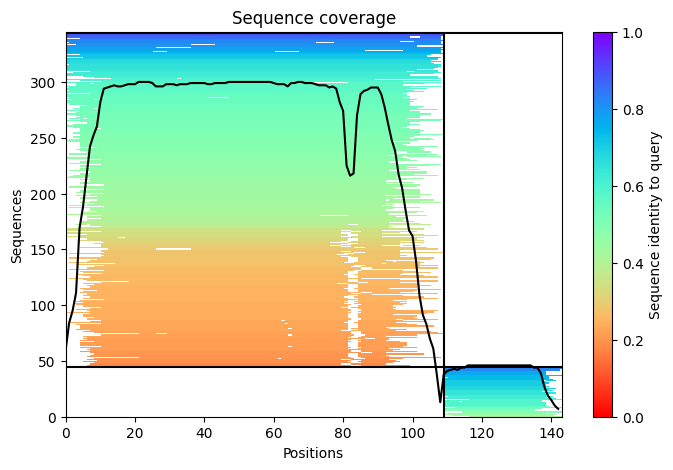

loading alphafold params
running prediction
seed=0 model=model_3_multimer_v3 recycle=0 plddt=0.709 ptm=0.656 i_ptm=0.374 multi=0.431
seed=0 model=model_3_multimer_v3 recycle=1 plddt=0.715 ptm=0.651 i_ptm=0.323 multi=0.389 rmsd_tol=2.137
seed=0 model=model_3_multimer_v3 recycle=2 plddt=0.723 ptm=0.656 i_ptm=0.374 multi=0.431 rmsd_tol=1.529
seed=0 model=model_3_multimer_v3 recycle=3 plddt=0.777 ptm=0.705 i_ptm=0.668 multi=0.675 rmsd_tol=3.178
seed=0 model=model_3_multimer_v3 recycle=4 plddt=0.779 ptm=0.707 i_ptm=0.685 multi=0.690 rmsd_tol=0.955
seed=0 model=model_3_multimer_v3 recycle=5 plddt=0.783 ptm=0.707 i_ptm=0.710 multi=0.709 rmsd_tol=2.463
seed=0 model=model_3_multimer_v3 recycle=6 plddt=0.786 ptm=0.707 i_ptm=0.712 multi=0.711 rmsd_tol=1.118


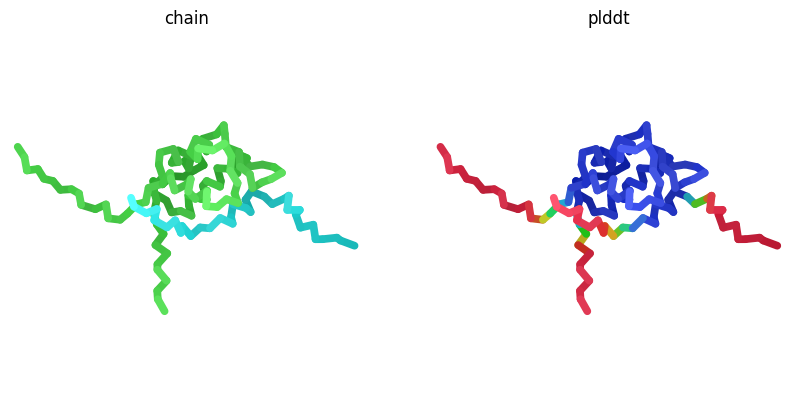

best_tag=model_3_multimer_v3_r6_seed0 seed=0 model=model_3_multimer_v3 recycle=6 plddt=0.786 ptm=0.707 i_ptm=0.712 multi=0.711 rmsd_tol=1.118


In [5]:
#@title Run MDM2-p53 with long peptide

sequence = 'SQIPASEQETLVRPKPLLLKLLKSVGAQKDTYTMKEVLFYLGQYIMTKRLYDEKQQHIVYCSNDLLGDLFGVPSFSVKEHRKIYTMIYRNLVVVNQQESSDSGTSVSEN:QSDPSVEPPLSQETFSDLWKLLPENNVLSPLPSQ'
af_long, jobname_long = run_alphafold(sequence, '1ycr_long')

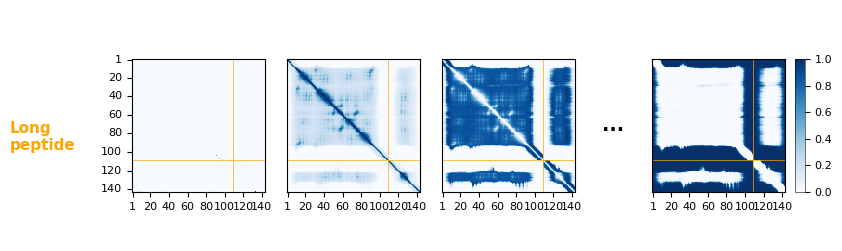

In [ ]:
fig_error_long, axes_long = create_error_probability_matrix_plot(af_long, 3, filename='error_prob_long_peptide.png', title='Long peptide', title_color='orange', add_bins=False)

In [6]:
#@title Calculate experimental contact map
from biopandas.pdb import PandasPdb
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns


def contact_map_pdb(pdb):
  # Load the PDB file
  ppdb = PandasPdb().fetch_pdb('1YCR')  # Replace with your PDB file or code

  # Extract atom data
  atoms = ppdb.df['ATOM']

  # Function to determine the relevant atom (CB or CA) for each residue
  def get_relevant_atoms(atom):
      if atom['residue_name'] == 'GLY':
          return atom['atom_name'] == 'CA'
      else:
          return atom['atom_name'] == 'CB'

  # Filter to get only CBs and CAs where appropriate
  filtered_atoms = atoms[atoms.apply(get_relevant_atoms, axis=1)]

  # Get coordinates
  coords = filtered_atoms[['x_coord', 'y_coord', 'z_coord']].values

  # Calculate the pairwise distance matrix
  dist_matrix = np.linalg.norm(coords[:, np.newaxis, :] - coords[np.newaxis, :, :], axis=2)

  # Define a distance cutoff (e.g., 8 angstroms) for contact
  cutoff = 8.0
  contact_map = dist_matrix <= cutoff

  return contact_map

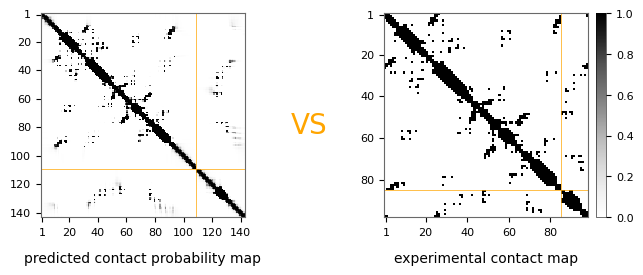

In [7]:
#@title Plot contact maps
from colabdesign.af.loss import get_contact_map

gs = gridspec.GridSpec(1, 3, width_ratios=[1, 0.25, 1.2])

# Creating a figure and axes
fig = plt.figure(figsize=(8, 3))

# Adjust layout to make room for the titles on the bottom
fig.subplots_adjust(bottom=0.2)

# Set residue numbering
ticks = np.arange(0, 143, 20)
ticks[0] = 1

# Display contact probability map
ax0 = fig.add_subplot(gs[0])
contact_prob_map = get_contact_map(af_long.aux['debug']['outputs'], 8)
sns.heatmap(contact_prob_map, cmap='Greys', square=True, vmin=0, vmax=1, ax=ax0)
ax0.axvline(x=109, color='orange', linestyle='-', lw=0.5)  # Add vertical line at x=109
ax0.axhline(y=109, color='orange', linestyle='-', lw=0.5)  # Add horizontal line at y=109

## Remove colorscale
ax0.collections[0].colorbar.remove()
## Add the title below the heatmap
ax0.text(0.5, -0.2, "predicted contact probability map", ha="center", va="center", transform=ax0.transAxes, fontsize=10)

## set ticklabels on both axis
ticks = np.arange(0, 141, 20)
ticks[0] = 1
ax0.set_xticks(ticks)
ax0.set_yticks(ticks)

ax0.set_xticklabels(ticks, size=8, rotation=0)
ax0.set_yticklabels(ticks, size=8)


# Calculate and display contact map from solved structure
ax2 = fig.add_subplot(gs[2])
exp_contact_map = contact_map_pdb('1YCR')
sns.heatmap(exp_contact_map, cmap='Greys', square=True, vmin=0, vmax=1, ax=ax2)
ax2.axvline(x=85, color='orange', linestyle='-', lw=0.5)  # Add vertical line at x=109
ax2.axhline(y=85, color='orange', linestyle='-', lw=0.5)  # Add horizontal line at y=109

## Add the title below the heatmap
ax2.text(0.5, -0.2, "experimental contact map", ha="center", va="center", transform=ax2.transAxes, fontsize=10)

## Set residue numbering
ticks = np.arange(0, 100, 20)
ticks[0] = 1

## set ticklabels on both axis
ax2.set_xticks(ticks)
ax2.set_yticks(ticks)

ax2.set_xticklabels(ticks, size=8, rotation=0)
ax2.set_yticklabels(ticks, size=8)

for ax in [ax0, ax2]:
  # Make sure all spines (borders) are visible
  for spine in ax.spines.values():
      spine.set_visible(True)
      # make them dimgray
      spine.set_color('dimgray')



# Change the size of the tick labels on the colorbar
cbar = ax2.collections[0].colorbar
cbar.ax.tick_params(labelsize=8)  # 12 is the font size
cbar.outline.set_edgecolor('black')  # Set the color of the border
cbar.outline.set_linewidth(0.4)      # Set the thickness of the border
cbar.ax.set_position([ax2.get_position().x1 + 0.01, ax2.get_position().y0, 0.02, ax2.get_position().height])

# Add text with VS
ax1=fig.add_subplot(gs[1])
ax1.axis('off')
ax1.text(0.5, 0.45, 'VS', horizontalalignment='center', verticalalignment='center', fontsize=20, transform=ax1.transAxes, color='orange')

plt.savefig('contact_maps.png', bbox_inches='tight', dpi=300)

plt.show()

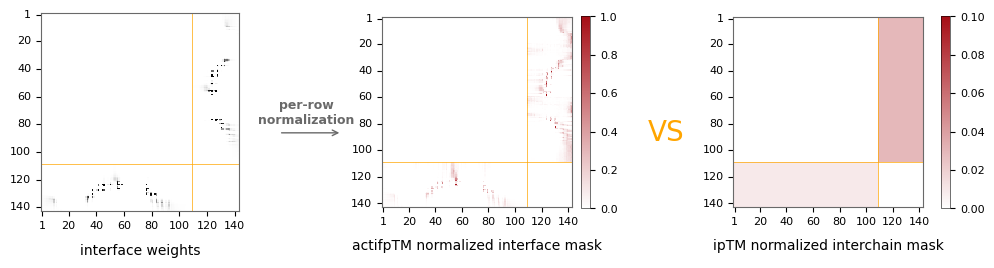

In [10]:
#@title Plot pair residue weights
import matplotlib.colors as mcolors

residue_weights = contact_prob_map

asym_id = af_long.aux['debug']['inputs']['asym_id']
pair_mask = asym_id[:, None] != asym_id[None, :]

# Creating a figure and axes
gs = gridspec.GridSpec(1, 5, width_ratios=[1, 0.4, 1.2, 0.25, 1.2])
fig = plt.figure(figsize=(12, 3))

# Adjust layout to make room for the titles on the bottom
fig.subplots_adjust(bottom=0.2)

# Set residue numbering
ticks = np.arange(0, 143, 20)
ticks[0] = 1


# unnormalized pair residue weights
ax0 = fig.add_subplot(gs[0])
pair_residue_weights = pair_mask * contact_prob_map
sns.heatmap(pair_residue_weights, cmap='Greys', square=True, vmin=0, vmax=1, ax=ax0)
ax0.axvline(x=109, color='orange', linestyle='-', lw=0.5)  # Add vertical line at x=109
ax0.axhline(y=109, color='orange', linestyle='-', lw=0.5)  # Add horizontal line at y=109
## Add the title below the heatmap
ax0.text(0.5, -0.2, "interface weights", ha="center", va="center", transform=ax0.transAxes, fontsize=10)
ax0.collections[0].colorbar.remove()


# normalized pair residue weights
red_cmap = mcolors.LinearSegmentedColormap.from_list("custom_red", ["#ffffff", "#a60e15"])
ax3 = fig.add_subplot(gs[2])
normed_residue_mask = pair_residue_weights / (1e-8 + pair_residue_weights.sum(-1, keepdims=True))
sns.heatmap(normed_residue_mask, cmap=red_cmap, square=True, vmin=0,  vmax=1, ax=ax3)
ax3.axvline(x=109, color='orange', linestyle='-', lw=0.5)  # Add vertical line at x=109
ax3.axhline(y=109, color='orange', linestyle='-', lw=0.5)  # Add horizontal line at y=109
## Add the title below the heatmap
ax3.text(0.5, -0.2, "actifpTM normalized interface mask", ha="center", va="center", transform=ax3.transAxes, fontsize=10)
# Change the size of the tick labels on the colorbar
cbar = ax3.collections[0].colorbar
cbar.ax.tick_params(labelsize=8)  # 12 is the font size
cbar.outline.set_edgecolor('black')  # Set the color of the border
cbar.outline.set_linewidth(0.4)      # Set the thickness of the border
cbar.ax.set_position([0.575, 0.22, 0.01, 0.64])  # [left, bottom, width, height]

# Calculate and display contact map from solved structure
iptm_pair_mask = asym_id[:, None] != asym_id[None, :]
iptm_residue_weights = np.full(contact_prob_map.shape[0], 1, dtype=float)
iptm_pair_residue_weights = iptm_pair_mask * (iptm_residue_weights[None, :] * iptm_residue_weights[:, None])
iptm_normalized_pair_mask = iptm_pair_residue_weights / (1e-8 + iptm_pair_residue_weights.sum(-1, keepdims=True))
ax5 = fig.add_subplot(gs[4])
sns.heatmap(iptm_normalized_pair_mask, cmap=red_cmap, square=True, vmin=0, vmax=0.1, ax=ax5)
ax5.axvline(x=109, color='orange', linestyle='-', lw=0.5)  # Add vertical line at x=109
ax5.axhline(y=109, color='orange', linestyle='-', lw=0.5)  # Add horizontal line at y=109

## Add the title below the heatmap
ax5.text(0.5, -0.2, "ipTM normalized interchain mask", ha="center", va="center", transform=ax5.transAxes, fontsize=10)

# Change the size of the tick labels on the colorbar
cbar = ax5.collections[0].colorbar
cbar.ax.tick_params(labelsize=8)  # 12 is the font size
cbar.outline.set_edgecolor('black')  # Set the color of the border
cbar.outline.set_linewidth(0.4)      # Set the thickness of the border
cbar.ax.set_position([0.875, 0.22, 0.01, 0.64])  # [left, bottom, width, height]

for ax in [ax0, ax3, ax5]:
  # set ticklabels on both axis
  ax.set_xticks(ticks)
  ax.set_xticklabels(ticks, size=8, rotation=0)
  ax.set_yticks(ticks)
  ax.set_yticklabels(ticks, size=8)

  # Make sure all spines (borders) are visible
  for spine in ax.spines.values():
      spine.set_visible(True)
      # make them dimgray
      spine.set_color('dimgray')

# Plot an arrow
ax1=fig.add_subplot(gs[1])
ax1.axis('off')
ax1.annotate(
    '', xytext=(0.1, 0.4), xy=(0.9, 0.4),
    arrowprops=dict(color='dimgrey', arrowstyle='->')
)

# Add text above the arrow
ax1.text(
    0.45, 0.5, 'per-row\nnormalization',
    horizontalalignment='center',
    verticalalignment='center',
    fontsize=9,
    color='dimgrey',
    weight='bold'
);


# Add text with VS
ax4=fig.add_subplot(gs[3])
ax4.axis('off')
ax4.text(0.3, 0.4, 'VS', horizontalalignment='center', verticalalignment='center', fontsize=20, transform=ax4.transAxes, color='orange');




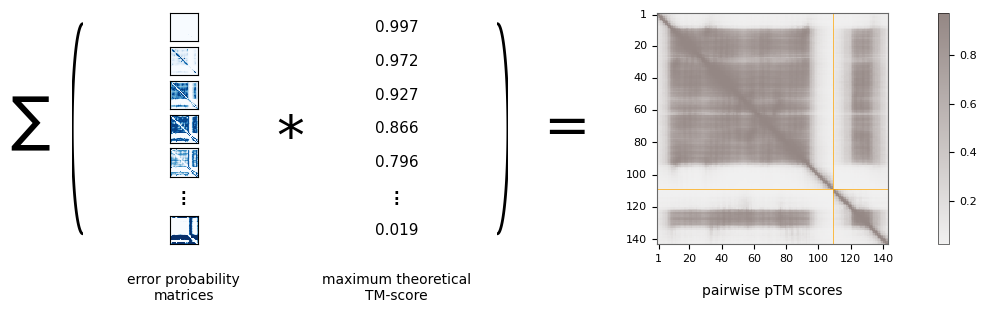

In [11]:
#@title Multiplication with maximum

### DATA ####
# Calculate theoretical maximum TM-score for each bin
from colabdesign.af.alphafold.common.confidence import _calculate_bin_centers
import matplotlib.transforms as transforms

logits = af_long.aux['debug']['outputs']["predicted_aligned_error"]['logits'][:, :, :]
probs = scipy.special.softmax(logits, axis=-1)

# Convert logits to probabilities
subset_extended = scipy.special.softmax(probs, axis=-1)

bins = np.arange(0,31.5, 0.5)
bin_centers = _calculate_bin_centers(bins, use_jnp=False)

clipped_num_res = np.maximum(probs.shape[0], 19)
d0 = 1.24 * (clipped_num_res - 15) ** (1./3) - 1.8
tm_per_bin = 1. / (1 + np.square(bin_centers) / np.square(d0))
# Reshape the vector to be a column
tm_per_bin_vector = tm_per_bin.reshape(-1, 1)
### DATA ####


### FIGURE ####
# Creating a figure and axes
num_plots = 5
height_ratios = [1] * (num_plots+2)
gs = gridspec.GridSpec(7, 6, width_ratios=[0.1, 0.1, 0.1, 0.1, 0.1, 0.5], height_ratios=height_ratios)
fig = plt.figure(figsize=(12, 3))

# Add first part of the plot
ax0 = fig.add_subplot(gs[:, 0])
ax0.axis('off')

# Optionally, add a summation symbol as a text annotation
ax0.text(-1, 0.5, r'$\sum$', fontsize=30, ha='center', va='center', color='black')

# plot a round bracket
# Parameters for the bracket shape
t = np.linspace(-np.pi/2, np.pi/2, 100)  # Parametric range for a semicircle
x = -np.cos(t)  # x-coordinates for the bracket (flipped for left direction)
y = np.sin(t)   # y-coordinates for the bracket (vertical shape)

# Scale the bracket vertically
y = y * 10

# Subset x and y to include only the necessary coordinates
subset_mask = (x >= -1) & (x <= 0)  # Keep x in range [-1, 0]

x_subset = x[subset_mask]
y_subset = y[subset_mask]
x_subset = x_subset + 4

# Plot the bracket
ax0.plot(x_subset, y_subset, color='black', lw=2)

# Set the aspect ratio to equal for consistency
ax0.set_aspect('equal')





# Get error probability matrices from the output
subset = af_long.aux['debug']['outputs']["predicted_aligned_error"]['logits'][:, :, :num_plots]
subset_extended = np.concatenate((subset, af_long.aux['debug']['outputs']["predicted_aligned_error"]['logits'][:, :, -1:]), axis=2)

# Convert logits to probabilities
subset_extended = scipy.special.softmax(subset_extended, axis=-1)

# Get sequence length
seq_len = subset_extended.shape[0]

# Number of heatmaps
num_heatmaps = subset_extended.shape[2]

# Define bins
bins = np.arange(0, math.floor(num_heatmaps/2)-0.5, 0.5)
bins = np.append(bins, 31)

# Define cmap
cmap = sns.color_palette("Blues", as_cmap=True)
cmap_ptm_score = sns.light_palette("#948784", as_cmap=True)



# Plot each heatmap
for i in range(6):
    if i == 5:
      l = 6
    else:
      l = i

    ax = fig.add_subplot(gs[l, 1])
    sns.heatmap(subset_extended[:, :, i], cmap=cmap, ax=ax, cbar=None, square=True,
                cbar_ax=None)

    # Remove y-axis tick labels for all except the first heatmap
    if i > 0:
        ax.set_yticks([])

    ax.set_yticks([])  # Set tick positions
    ax.set_yticklabels([])  # Set tick labels

    # Have ticks at every 10 for all x-axis
    ax.set_xticks([])  # Set tick positions
    ax.set_xticklabels([])  # Set tick labels

    # Make sure all spines (borders) are visible
    for spine in ax.spines.values():
        spine.set_visible(True)


# Add plot with dots
ax=fig.add_subplot(gs[5, 1])
ax.axis('off')
ax.text(0.5, 1, '.\n.\n.', ha='center', va='top', fontsize=11,
        transform=ax.transAxes, weight='bold', linespacing=0.2)

ax.text(0.5, -2.75, "error probability\nmatrices", ha="center", va="center", transform=ax.transAxes, fontsize=10)



# Add asterisk
ax2 = fig.add_subplot(gs[:, 2])
ax2.axis('off')
ax2.text(0.5, 0.45, '*', horizontalalignment='center', verticalalignment='center', fontsize=40,
        transform=ax2.transAxes)


# List of numbers to print
maxTM = tm_per_bin[:5].tolist()
maxTM.append('\n'.join(['.'] * 3))
maxTM.append(float(tm_per_bin[-1]))
# Loop through the numbers and print them on the plot
for i, number in enumerate(maxTM):
    ax3 = fig.add_subplot(gs[i, 3])
    ax3.axis('off')
    if type(number) == float:
      ax3.text(0.5, 0.5, str(round(number, 3)), ha='center', va='center', fontsize=11,
          transform=ax3.transAxes, linespacing=0.2)
    else:
      ax3.text(0.5, 1, number, ha='center', va='top', fontsize=11,
          transform=ax3.transAxes, weight='bold', linespacing=0.2)
ax3.text(0.5, -1.55, "maximum theoretical\nTM-score", ha="center", va="center", transform=ax3.transAxes, fontsize=10)


# Add first part of the plot
ax4 = fig.add_subplot(gs[:, 4])
ax4.axis('off')

# Optionally, add a summation symbol as a text annotation
ax4.text(6, 0.5, '=', fontsize=40, ha='center', va='center', color='black', transform=ax4.transAxes)

# plot a round bracket
# Parameters for the bracket shape
t = np.linspace(-np.pi/2, np.pi/2, 100)  # Parametric range for a semicircle
x = np.cos(t)  # x-coordinates for the bracket (flipped for left direction)
y = np.sin(t)   # y-coordinates for the bracket (vertical shape)

# Scale the bracket vertically
y = y * 10

# Subset x and y to include only the necessary coordinates
subset_mask = (x >= 0) & (x <= 1)  # Keep x in range [-1, 0]

x_subset = x[subset_mask]
y_subset = y[subset_mask]
x_subset = x_subset

# Plot the bracket
ax4.plot(x_subset, y_subset, color='black', lw=2)

# Set the aspect ratio to equal for consistency
ax4.set_aspect('equal')


# Add heatmap with predicted TM terms
ax5 = fig.add_subplot(gs[:, 5])
predicted_tm_term = (probs * tm_per_bin).sum(-1)
sns.heatmap(predicted_tm_term, cmap=cmap_ptm_score, square=True, ax=ax5)
ax5.axvline(x=109, color='orange', linestyle='-', lw=0.5)  # Add vertical line at x=109
ax5.axhline(y=109, color='orange', linestyle='-', lw=0.5)  # Add horizontal line at y=109

## Add the title below the heatmap
ax5.text(0.5, -0.2, "pairwise pTM scores", ha="center", va="center", transform=ax5.transAxes, fontsize=10)

# Change the size of the tick labels on the colorbar
cbar = ax5.collections[0].colorbar
cbar.ax.tick_params(labelsize=8)  # 12 is the font size
cbar.outline.set_edgecolor('black')  # Set the color of the border
cbar.outline.set_linewidth(0.4)      # Set the thickness of the border
cbar.ax.set_position([0.875, 0.11, 0.01, 0.77])  # [left, bottom, width, height]

# set ticklabels on both axis
ax5.set_xticks(ticks)
ax5.set_xticklabels(ticks, size=8, rotation=0)
ax5.set_yticks(ticks)
ax5.set_yticklabels(ticks, size=8)

# Make sure all spines (borders) are visible
for spine in ax5.spines.values():
    spine.set_visible(True)
    # make them dimgray
    spine.set_color('dimgray')


plt.show()

<class 'jaxlib.xla_extension.ArrayImpl'>


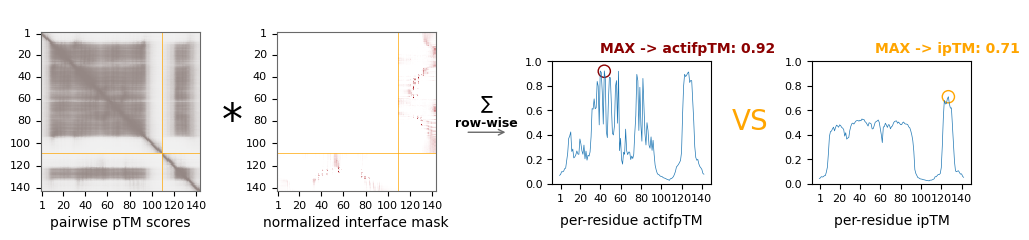

In [12]:
#@title Last steps
gs = gridspec.GridSpec(1, 7, width_ratios=[2, 0.4, 2, 0.9, 2, 0.7, 2])
fig = plt.figure(figsize=(12, 3))

# Adjust layout to make room for the titles on the bottom
fig.subplots_adjust(bottom=0.2)

# Add heatmap with predicted TM terms
ax0 = fig.add_subplot(gs[0])
sns.heatmap(predicted_tm_term, cmap=cmap_ptm_score, square=True, ax=ax0, cbar=None)
ax0.axvline(x=109, color='orange', linestyle='-', lw=0.5)  # Add vertical line at x=109
ax0.axhline(y=109, color='orange', linestyle='-', lw=0.5)  # Add horizontal line at y=109

## Add the title below the heatmap
ax0.text(0.5, -0.2, "pairwise pTM scores", ha="center", va="center", transform=ax0.transAxes, fontsize=10)

# Change the size of the tick labels on the colorbar
#cbar = ax0.collections[0].colorbar
#cbar.ax.tick_params(labelsize=8)  # 12 is the font size
#cbar.outline.set_edgecolor('black')  # Set the color of the border
#cbar.outline.set_linewidth(0.4)      # Set the thickness of the border
#cbar.ax.set_position([0.875, 0.15, 0.01, 0.8])  # [left, bottom, width, height]

# set ticklabels on both axis
ax0.set_xticks(ticks)
ax0.set_xticklabels(ticks, size=8, rotation=0)
ax0.set_yticks(ticks)
ax0.set_yticklabels(ticks, size=8)

# Make sure all spines (borders) are visible
for spine in ax0.spines.values():
    spine.set_visible(True)
    # make them dimgray
    spine.set_color('dimgray')


# Add asterisk
ax1 = fig.add_subplot(gs[1])
ax1.axis('off')
ax1.text(0.3, 0.45, '*', horizontalalignment='center', verticalalignment='center', fontsize=30,
        transform=ax1.transAxes)



# normalized pair residue weights
ax2 = fig.add_subplot(gs[2])
normed_residue_mask = pair_residue_weights / (1e-8 + pair_residue_weights.sum(-1, keepdims=True))
sns.heatmap(normed_residue_mask, cmap=red_cmap, square=True, vmin=0,  vmax=1, ax=ax2)
ax2.axvline(x=109, color='orange', linestyle='-', lw=0.5)  # Add vertical line at x=109
ax2.axhline(y=109, color='orange', linestyle='-', lw=0.5)  # Add horizontal line at y=109
## Add the title below the heatmap
ax2.text(0.5, -0.2, "normalized interface mask", ha="center", va="center", transform=ax2.transAxes, fontsize=10)
ax2.collections[0].colorbar.remove()

# Set ticklabels on both axis
ax2.set_xticks(ticks)
ax2.set_xticklabels(ticks, size=8, rotation=0)
ax2.set_yticks(ticks)
ax2.set_yticklabels(ticks, size=8)

# Make sure all spines (borders) are visible
for spine in ax2.spines.values():
    spine.set_visible(True)
    # make them dimgray
    spine.set_color('dimgray')



# Plot an arrow and sum
ax3 = fig.add_subplot(gs[3])
ax3.axis('off')
ax3.annotate(
    '', xytext=(0.1, 0.4), xy=(0.7, 0.4),
    arrowprops=dict(color='dimgrey', arrowstyle='->')
)

# Add text above the arrow
ax3.text(
    0.4, 0.5, r'$\sum$'+'\nrow-wise',
    horizontalalignment='center',
    verticalalignment='center',
    fontsize=9,
    #color='dimgrey',
    weight='bold',
    transform=ax3.transAxes
)

# residue-wise ifpTM score
per_alignment = (predicted_tm_term * normed_residue_mask).sum(-1)
ax4 = fig.add_subplot(gs[4])
sns.lineplot(data=per_alignment, markers=True, dashes=False, ax=ax4, linewidth=0.5)
ax4.set_ylim(0, 1)
ax4.set_xticks(ticks);
ax4.set_xticklabels(ticks, size=8, rotation=0);
ax4.tick_params(axis='y', labelsize=8);
pos = ax4.get_position()
ax4.set_position([pos.x0, pos.y0+0.1, pos.width, 0.6*pos.height])

# add a dark red circle around the maximum value on ax4
from matplotlib.patches import Ellipse, Circle
print(type(per_alignment.max()))
max_value = round(float(per_alignment.max()),2)
max_index = per_alignment.argmax()
circle = Ellipse((max_index, max_value), 12, 0.1, color='darkred', fill=False, linewidth=1)
ax4.text(0.85, 1.1, f"MAX -> actifpTM: {round(max_value, 2)}", ha="center", va="center", transform=ax4.transAxes, fontsize=10, color='darkred', weight='bold')
ax4.text(0.5, -0.3, "per-residue actifpTM", ha="center", va="center", transform=ax4.transAxes, fontsize=10)
ax4.add_artist(circle)

# Add text with VS
ax5=fig.add_subplot(gs[5])
ax5.axis('off')
ax5.text(0.3, 0.45, 'VS', horizontalalignment='center', verticalalignment='center', fontsize=20, transform=ax5.transAxes, color='orange');

# calculate ipTM
iptm_pair_mask = asym_id[:, None] != asym_id[None, :]
iptm_residue_weights = np.full(contact_prob_map.shape[0], 1, dtype=float)
iptm_pair_residue_weights = iptm_pair_mask * (iptm_residue_weights[None, :] * iptm_residue_weights[:, None])
iptm_normalized_pair_mask = iptm_pair_residue_weights / (1e-8 + iptm_pair_residue_weights.sum(-1, keepdims=True))
iptm_per_alignment = (predicted_tm_term * iptm_normalized_pair_mask).sum(-1)

# residue-wise ipTM score
iptm_predicted_tm_term = predicted_tm_term * pair_mask
iptm_per_alignment = (iptm_predicted_tm_term * iptm_normalized_pair_mask).sum(-1)
ax6 = fig.add_subplot(gs[6])
sns.lineplot(data=iptm_per_alignment, markers=True, dashes=False, ax=ax6, linewidth=0.5)
ax6.set_ylim(0, 1)
ax6.set_xticks(ticks);
ax6.set_xticklabels(ticks, size=8, rotation=0);
ax6.tick_params(axis='y', labelsize=8);
pos = ax6.get_position()
ax6.set_position([pos.x0, pos.y0+0.1, pos.width, 0.6*pos.height])
ax6.text(0.5, -0.3, "per-residue ipTM", ha="center", va="center", transform=ax6.transAxes, fontsize=10)

# add a dark red circle around the maximum value on ax4
from matplotlib.patches import Ellipse, Circle
iptm_max_value = iptm_per_alignment.max()
iptm_max_index = iptm_per_alignment.argmax()
circle = Ellipse((iptm_max_index, iptm_max_value), 12, 0.1, color='orange', fill=False, linewidth=1)
ax6.text(0.85, 1.1, f"MAX -> ipTM: {round(iptm_max_value, 2)}", ha="center", va="center", transform=ax6.transAxes, fontsize=10, color='orange', weight='bold')
ax6.add_artist(circle)

<class 'numpy.float64'>


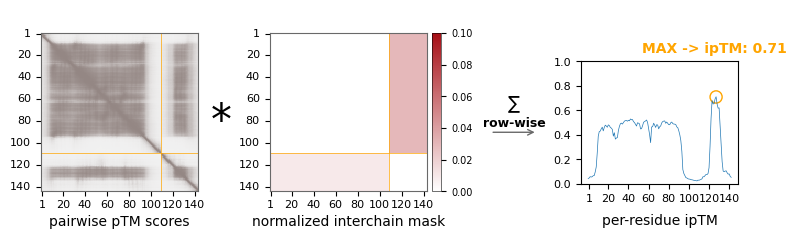

In [15]:
#@title Last steps - ipTM
gs = gridspec.GridSpec(1, 6, width_ratios=[2, 0.4, 2, 0.2, 1, 2])
fig = plt.figure(figsize=(9, 3))

# Adjust layout to make room for the titles on the bottom
fig.subplots_adjust(bottom=0.2)

# Add heatmap with predicted TM terms
ax0 = fig.add_subplot(gs[0])
sns.heatmap(predicted_tm_term, cmap=cmap_ptm_score, square=True, ax=ax0, cbar=None)
ax0.axvline(x=109, color='orange', linestyle='-', lw=0.5)  # Add vertical line at x=109
ax0.axhline(y=109, color='orange', linestyle='-', lw=0.5)  # Add horizontal line at y=109

## Add the title below the heatmap
ax0.text(0.5, -0.2, "pairwise pTM scores", ha="center", va="center", transform=ax0.transAxes, fontsize=10)

# set ticklabels on both axis
ax0.set_xticks(ticks)
ax0.set_xticklabels(ticks, size=8, rotation=0)
ax0.set_yticks(ticks)
ax0.set_yticklabels(ticks, size=8)

# Make sure all spines (borders) are visible
for spine in ax0.spines.values():
    spine.set_visible(True)
    # make them dimgray
    spine.set_color('dimgray')

# add asterisk
ax1 = fig.add_subplot(gs[1])
ax1.axis('off')
ax1.text(0.1, 0.45, '*', horizontalalignment='center', verticalalignment='center', fontsize=30,
        transform=ax1.transAxes)

# normalized pair residue weights
ax2 = fig.add_subplot(gs[2])
ax3 = fig.add_subplot(gs[3])
sns.heatmap(iptm_normalized_pair_mask, cmap=red_cmap, square=True, vmin=0,  vmax=0.1, ax=ax2, cbar_ax=ax3)
ax2.axvline(x=109, color='orange', linestyle='-', lw=0.5)  # Add vertical line at x=109
ax2.axhline(y=109, color='orange', linestyle='-', lw=0.5)  # Add horizontal line at y=109
## Add the title below the heatmap
ax2.text(0.5, -0.2, "normalized interchain mask", ha="center", va="center", transform=ax2.transAxes, fontsize=10)

# Change the size of the tick labels on the colorbar
cbar = ax2.collections[0].colorbar
cbar.ax.tick_params(labelsize=7)  # 12 is the font size
cbar.outline.set_edgecolor('black')  # Set the color of the border
cbar.outline.set_linewidth(0.4)      # Set the thickness of the border
cbar.ax.set_position([0.56, 0.275, 0.01, 0.5275])  # [left, bottom, width, height]

# Set ticklabels on both axis
ax2.set_xticks(ticks)
ax2.set_xticklabels(ticks, size=8, rotation=0)
ax2.set_yticks(ticks)
ax2.set_yticklabels(ticks, size=8)

# Make sure all spines (borders) are visible
for spine in ax2.spines.values():
    spine.set_visible(True)
    # make them dimgray
    spine.set_color('dimgray')

# Plot an arrow and sum
ax4 = fig.add_subplot(gs[4])
ax4.axis('off')
ax4.annotate(
    '', xytext=(0.1, 0.4), xy=(0.7, 0.4),
    arrowprops=dict(color='dimgrey', arrowstyle='->')
)

# Add text above the arrow
ax4.text(
    0.4, 0.5, r'$\sum$'+'\nrow-wise',
    horizontalalignment='center',
    verticalalignment='center',
    fontsize=9,
    #color='dimgrey',
    weight='bold',
    transform=ax4.transAxes
)

# residue-wise ipTM score
ax5 = fig.add_subplot(gs[5])
sns.lineplot(data=iptm_per_alignment, markers=True, dashes=False, ax=ax5, linewidth=0.5)
ax5.set_ylim(0, 1)
ax5.set_xticks(ticks);
ax5.set_xticklabels(ticks, size=8, rotation=0);
ax5.tick_params(axis='y', labelsize=8);
pos = ax5.get_position()
ax5.set_position([pos.x0, pos.y0+0.1, pos.width, 0.6*pos.height])

# add a dark red circle around the maximum value on ax4
from matplotlib.patches import Ellipse, Circle
print(type(iptm_per_alignment.max()))
max_value = round(float(iptm_per_alignment.max()),2)
max_index = iptm_per_alignment.argmax()
circle = Ellipse((max_index, max_value), 12, 0.1, color='orange', fill=False, linewidth=1)
ax5.text(0.85, 1.1, f"MAX -> ipTM: {round(max_value, 2)}", ha="center", va="center", transform=ax5.transAxes, fontsize=10, color='orange', weight='bold')
ax5.text(0.5, -0.3, "per-residue ipTM", ha="center", va="center", transform=ax5.transAxes, fontsize=10)
ax5.add_artist(circle)

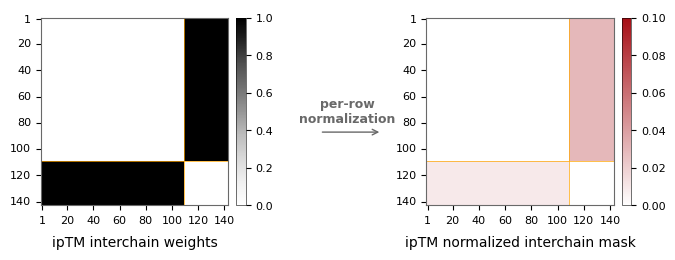

In [ ]:
#@title Plot ipTM pair residue weights
import matplotlib.colors as mcolors

residue_weights = contact_prob_map

asym_id = af_long.aux['debug']['inputs']['asym_id']
pair_mask = asym_id[:, None] != asym_id[None, :]

# Creating a figure and axes
gs = gridspec.GridSpec(1, 3, width_ratios=[1.2, 0.4, 1.2])
fig = plt.figure(figsize=(8, 3))

# Adjust layout to make room for the titles on the bottom
fig.subplots_adjust(bottom=0.2)

# Set residue numbering
ticks = np.arange(0, 143, 20)
ticks[0] = 1


# unnormalized pair residue weights
ax0 = fig.add_subplot(gs[0])
sns.heatmap(iptm_pair_residue_weights, cmap='Greys', square=True, vmin=0, vmax=1, ax=ax0)
ax0.axvline(x=109, color='orange', linestyle='-', lw=0.5)  # Add vertical line at x=109
ax0.axhline(y=109, color='orange', linestyle='-', lw=0.5)  # Add horizontal line at y=109
## Add the title below the heatmap
ax0.text(0.5, -0.2, "ipTM interchain weights", ha="center", va="center", transform=ax0.transAxes, fontsize=10)
#ax0.collections[0].colorbar.remove()

cbar = ax0.collections[0].colorbar
cbar.ax.tick_params(labelsize=8)  # 12 is the font size
cbar.outline.set_edgecolor('black')  # Set the color of the border
cbar.outline.set_linewidth(0.4)      # Set the thickness of the border
cbar.ax.set_position([ax0.get_position().x1 + 0.01, ax0.get_position().y0, 0.02, ax0.get_position().height])

# normalized pair residue weights
red_cmap = mcolors.LinearSegmentedColormap.from_list("custom_red", ["#ffffff", "#a60e15"])
ax3 = fig.add_subplot(gs[2])

# Calculate and display contact map from solved structure
iptm_pair_mask = asym_id[:, None] != asym_id[None, :]
iptm_residue_weights = np.full(contact_prob_map.shape[0], 1, dtype=float)
iptm_pair_residue_weights = iptm_pair_mask * (iptm_residue_weights[None, :] * iptm_residue_weights[:, None])
iptm_normalized_pair_mask = iptm_pair_residue_weights / (1e-8 + iptm_pair_residue_weights.sum(-1, keepdims=True))
sns.heatmap(iptm_normalized_pair_mask, cmap=red_cmap, square=True, vmin=0, vmax=0.1, ax=ax3)
ax3.axvline(x=109, color='orange', linestyle='-', lw=0.5)  # Add vertical line at x=109
ax3.axhline(y=109, color='orange', linestyle='-', lw=0.5)  # Add horizontal line at y=109

## Add the title below the heatmap
ax3.text(0.5, -0.2, "ipTM normalized interchain mask", ha="center", va="center", transform=ax3.transAxes, fontsize=10)

# Change the size of the tick labels on the colorbar
cbar = ax3.collections[0].colorbar
cbar.ax.tick_params(labelsize=8)  # 12 is the font size
cbar.outline.set_edgecolor('black')  # Set the color of the border
cbar.outline.set_linewidth(0.4)      # Set the thickness of the border
cbar.ax.set_position([ax3.get_position().x1 + 0.01, ax3.get_position().y0, 0.02, ax3.get_position().height])

for ax in [ax0, ax3]:
  # set ticklabels on both axis
  ax.set_xticks(ticks)
  ax.set_xticklabels(ticks, size=8, rotation=0)
  ax.set_yticks(ticks)
  ax.set_yticklabels(ticks, size=8)

  # Make sure all spines (borders) are visible
  for spine in ax.spines.values():
      spine.set_visible(True)
      # make them dimgray
      spine.set_color('dimgray')

# Plot an arrow
ax1=fig.add_subplot(gs[1])
ax1.axis('off')
ax1.annotate(
    '', xytext=(0.1, 0.4), xy=(0.9, 0.4),
    arrowprops=dict(color='dimgrey', arrowstyle='->')
)

# Add text above the arrow
ax1.text(
    0.45, 0.5, 'per-row\nnormalization',
    horizontalalignment='center',
    verticalalignment='center',
    fontsize=9,
    color='dimgrey',
    weight='bold'
);



jobname 1ycr_short_c725b
length=[109, 14] copies=1
/content
getting paired MSA


COMPLETE: 100%|██████████| 300/300 [elapsed: 00:01 remaining: 00:00]


getting unpaired MSA


COMPLETE: 100%|██████████| 300/300 [elapsed: 00:01 remaining: 00:00]


parsing msas
gathering info
filtering sequences
selecting final sequences


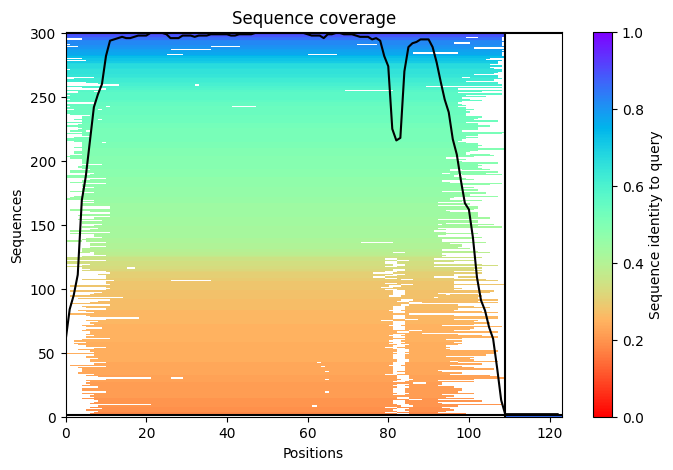

loading alphafold params
running prediction
seed=0 model=model_3_multimer_v3 recycle=0 plddt=0.844 ptm=0.761 i_ptm=0.783 multi=0.779
seed=0 model=model_3_multimer_v3 recycle=1 plddt=0.865 ptm=0.780 i_ptm=0.861 multi=0.844 rmsd_tol=1.488
seed=0 model=model_3_multimer_v3 recycle=2 plddt=0.865 ptm=0.780 i_ptm=0.857 multi=0.842 rmsd_tol=0.747
seed=0 model=model_3_multimer_v3 recycle=3 plddt=0.865 ptm=0.779 i_ptm=0.854 multi=0.839 rmsd_tol=0.272
seed=0 model=model_3_multimer_v3 recycle=4 plddt=0.866 ptm=0.779 i_ptm=0.855 multi=0.840 rmsd_tol=0.105
seed=0 model=model_3_multimer_v3 recycle=5 plddt=0.865 ptm=0.778 i_ptm=0.852 multi=0.837 rmsd_tol=0.328
seed=0 model=model_3_multimer_v3 recycle=6 plddt=0.864 ptm=0.778 i_ptm=0.854 multi=0.838 rmsd_tol=0.159


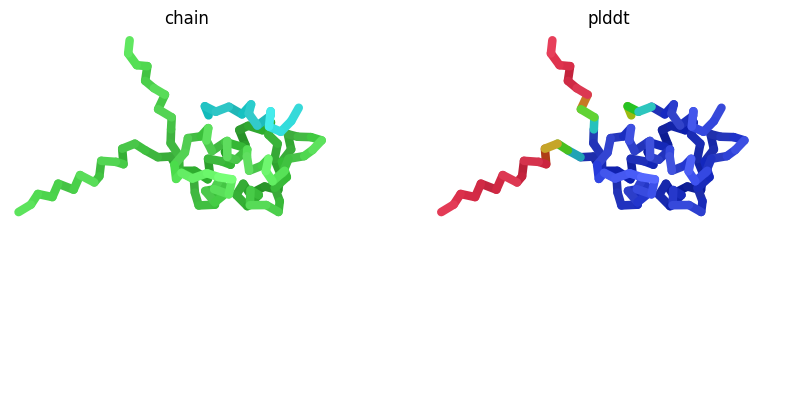

best_tag=model_3_multimer_v3_r6_seed0 seed=0 model=model_3_multimer_v3 recycle=6 plddt=0.864 ptm=0.778 i_ptm=0.854 multi=0.838 rmsd_tol=0.159


In [ ]:
#@title Run MDM2-p53 with short peptide
sequence = 'SQIPASEQETLVRPKPLLLKLLKSVGAQKDTYTMKEVLFYLGQYIMTKRLYDEKQQHIVYCSNDLLGDLFGVPSFSVKEHRKIYTMIYRNLVVVNQQESSDSGTSVSEN:ETFSDLWKLLPENN'
af_short, jobname_short = run_alphafold(sequence, '1ycr_short')

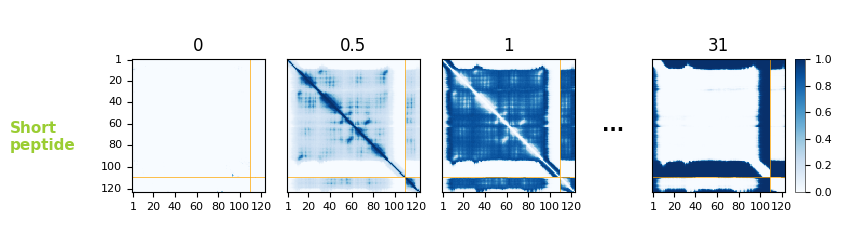

In [ ]:
fig_error_short, axes_short = create_error_probability_matrix_plot(af_short, 3, filename='error_prob_short_peptide.png', title='Short peptide', title_color='yellowgreen')

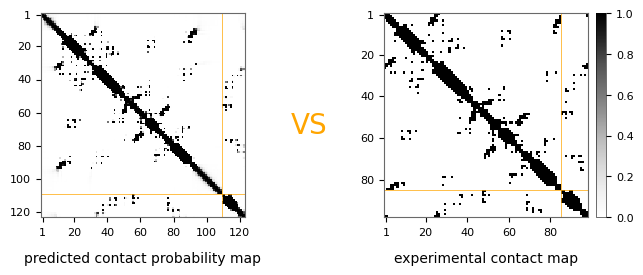

In [ ]:
#@title Plot contact maps
from colabdesign.af.loss import get_contact_map

gs = gridspec.GridSpec(1, 3, width_ratios=[1, 0.25, 1.2])

# Creating a figure and axes
fig = plt.figure(figsize=(8, 3))

# Adjust layout to make room for the titles on the bottom
fig.subplots_adjust(bottom=0.2)

# Set residue numbering
ticks = np.arange(0, 143, 20)
ticks[0] = 1

# Display contact probability map
ax0 = fig.add_subplot(gs[0])
contact_prob_map = get_contact_map(af_short.aux['debug']['outputs'], 8)
sns.heatmap(contact_prob_map, cmap='Greys', square=True, vmin=0, vmax=1, ax=ax0)
ax0.axvline(x=109, color='orange', linestyle='-', lw=0.5)  # Add vertical line at x=109
ax0.axhline(y=109, color='orange', linestyle='-', lw=0.5)  # Add horizontal line at y=109

## Remove colorscale
ax0.collections[0].colorbar.remove()
## Add the title below the heatmap
ax0.text(0.5, -0.2, "predicted contact probability map", ha="center", va="center", transform=ax0.transAxes, fontsize=10)

## set ticklabels on both axis
ticks = np.arange(0, 123, 20)
ticks[0] = 1
ax0.set_xticks(ticks)
ax0.set_yticks(ticks)

ax0.set_xticklabels(ticks, size=8, rotation=0)
ax0.set_yticklabels(ticks, size=8)


# Calculate and display contact map from solved structure
ax2 = fig.add_subplot(gs[2])
exp_contact_map = contact_map_pdb('1YCR')
sns.heatmap(exp_contact_map, cmap='Greys', square=True, vmin=0, vmax=1, ax=ax2)
ax2.axvline(x=85, color='orange', linestyle='-', lw=0.5)
ax2.axhline(y=85, color='orange', linestyle='-', lw=0.5)

## Add the title below the heatmap
ax2.text(0.5, -0.2, "experimental contact map", ha="center", va="center", transform=ax2.transAxes, fontsize=10)

## Set residue numbering
ticks = np.arange(0, 100, 20)
ticks[0] = 1

## set ticklabels on both axis
ax2.set_xticks(ticks)
ax2.set_yticks(ticks)

ax2.set_xticklabels(ticks, size=8, rotation=0)
ax2.set_yticklabels(ticks, size=8)

for ax in [ax0, ax2]:
  # Make sure all spines (borders) are visible
  for spine in ax.spines.values():
      spine.set_visible(True)
      # make them dimgray
      spine.set_color('dimgray')



# Change the size of the tick labels on the colorbar
cbar = ax2.collections[0].colorbar
cbar.ax.tick_params(labelsize=8)  # 12 is the font size
cbar.outline.set_edgecolor('black')  # Set the color of the border
cbar.outline.set_linewidth(0.4)      # Set the thickness of the border
cbar.ax.set_position([ax2.get_position().x1 + 0.01, ax2.get_position().y0, 0.02, ax2.get_position().height])

# Add text with VS
ax1=fig.add_subplot(gs[1])
ax1.axis('off')
ax1.text(0.5, 0.45, 'VS', horizontalalignment='center', verticalalignment='center', fontsize=20, transform=ax1.transAxes, color='orange')

plt.savefig('contact_maps.png', bbox_inches='tight', dpi=300)

plt.show()